Construct a $P_0(k)$ emulator that depends on two parameters: $\alpha$ and $\log\,M_1$

In [1]:
import numpy as np 
import george as George
import scipy.optimize as op
# -- local -- 
import env
import lhd as LHD
import data as Data
import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# 1D Latin Hypercube Design
lhd_2d = LHD.LHD(2, samples=17, method='mdu')
print lhd_2d

[[ 0.45162143  0.50324711]
 [ 0.58921105  0.97233239]
 [ 0.97129959  0.66128543]
 [ 0.83685269  0.29959428]
 [ 0.56736311  0.22924799]
 [ 0.24555097  0.64120106]
 [ 0.68770222  0.03724126]
 [ 0.02274914  0.54935469]
 [ 0.17274882  0.1381888 ]
 [ 0.36103064  0.1015268 ]
 [ 0.31418037  0.81747707]
 [ 0.7713808   0.87571097]
 [ 0.23086433  0.39881621]
 [ 0.93396114  0.92011951]
 [ 0.48576127  0.41671412]
 [ 0.09764612  0.24480169]
 [ 0.75395425  0.75873848]]


In [6]:
thetas = np.zeros((lhd_2d.shape[0], 5))
thetas[:,0] = 11.60 # log M_min
thetas[:,1] = 0.26  # sigma_logM
thetas[:,2] = 11.49 # log M0
thetas[:,3] = 12.2 + lhd_2d[:,0].flatten()  # log M1
thetas[:,4] = 0.5 + lhd_2d[:,1].flatten() # alpha sampled by LHD 

In [12]:
thetas_test = np.zeros((10,5))
thetas_test[:,0] = 11.60
thetas_test[:,1] = 0.26 # sigma_logM
thetas_test[:,2] = 11.49 # log M0
i_rand = np.arange(10)
np.random.shuffle(i_rand)
thetas_test[:,3] = 12.3+0.08*i_rand  # log M1
i_rand = np.arange(10)
np.random.shuffle(i_rand)
thetas_test[:,4] = 0.6 +0.08*i_rand # alpha sampled by LHD 

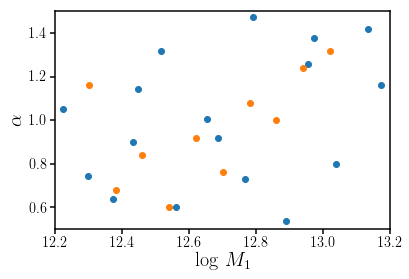

In [13]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(thetas[:,3], thetas[:,4])
sub.scatter(thetas_train[:,3], thetas_train[:,4])
sub.set_xlim([12.2, 13.2])
sub.set_xlabel(r'$\log\,M_1$', fontsize=20)
sub.set_ylim([0.5, 1.5])
sub.set_ylabel(r'$\alpha$', fontsize=20)

Now lets construct the training $P_0$s from the LHD

In [14]:
# halo catalog 
halos = Data.NeutHalos(0.0, 1, 4)

In [15]:
def BigF(theta, halos): 
    # F(theta) --- i.e. the galaxy catalog generated
    # from the halo catalog
    p_hod = {'logMmin': theta[0], 'sigma_logM': theta[1], 'logM0': theta[2], 'logM1': theta[3], 'alpha': theta[4]}
    g = FM.Galaxies(halos, p_hod, seed=seed)
    g['RSDPosition'] = FM.RSD(g, LOS=[0,0,1]) # impose RSD
    return g

def ObvsBigF(bigf, obvs='p0k'):
    # measure P(k) from F(theta)
    plk = FM.Observables(bigf, observable='plk', rsd=True, Nmesh=180)
    if obvs == 'p0k': 
        return plk['k'], plk['p0k']

In [16]:
seed = 1
p0k_lhd = []
for i in range(thetas.shape[0]): 
    gals_i = BigF(thetas[i,:], halos)
    kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    p0k_lhd.append(p0k_i)
    if i == 0: karr = kk
p0k_lhd = np.array(p0k_lhd)

Precompute testing $P_0$

In [17]:
p0k_test = []
for i in range(thetas_test.shape[0]): 
    gals_i = BigF(thetas_test[i,:], halos)
    _, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    p0k_test.append(p0k_i)
    if i == 0: karr = kk
p0k_test = np.array(p0k_test)

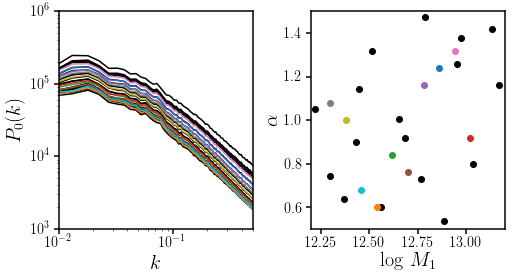

In [18]:
fig = plt.figure(figsize=(8, 4))
sub1 = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
for i in range(p0k_lhd.shape[0]): 
    sub1.plot(karr, p0k_lhd[i,:], c='k')    
    sub2.scatter([thetas[i,3]], [thetas[i,4]], c='k')

for i in range(p0k_test.shape[0]):
    sub1.plot(karr, p0k_test[i,:], c='C'+str(i))
    sub2.scatter([thetas_test[i,3]], [thetas_test[i,4]], c='C'+str(i))
sub1.set_xscale('log')
sub1.set_xlim([0.01, 0.5])
sub1.set_xlabel('$k$', fontsize=20)
sub1.set_yscale('log')
sub1.set_ylim([1e3, 1e6])
sub1.set_ylabel('$P_0(k)$', fontsize=20)

sub2.set_xlim([12.2, 13.2])
sub2.set_xlabel(r'$\log\,M_1$', fontsize=20)
sub2.set_ylim([0.5, 1.5])
sub2.set_ylabel(r'$\alpha$', fontsize=20)
fig.subplots_adjust(wspace=0.3)

In [19]:
def trainGP(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        gps.append(gp)
    return gps

In [20]:
def trainGP_opt(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        # optimize hyperparameters
        p0 = gp.get_parameter_vector()
        results = op.minimize(gp.nll, p0, args=(Y[:,i]), jac=gp.grad_nll, method='L-BFGS-B')
        gp.set_parameter_vector(results.x)
        gps.append(gp)
    return gps

In [21]:
def emu(x_pred, gps, Y): 
    # use GPs to predict Plk at x_pred
    mus, vs = [], [] 
    for i, gp in enumerate(gps): 
        mu, var = gp.predict(Y[:,i], x_pred)
        mus.append(mu)
        vs.append(var)
    return np.array(mus).T, np.array(vs).T

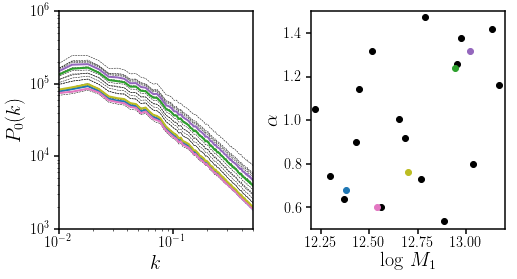

In [75]:
X_train = thetas[:,3:]
mu_p0k_train = np.sum(p0k_lhd, axis=0)/float(p0k_lhd.shape[0])
sig_p0k_train = np.std(p0k_lhd, axis=0)
Y_train = (p0k_lhd - mu_p0k_train)/sig_p0k_train
gp_emu = trainGP(X_train, Y_train)

# testing set
X_test = thetas_train[:,3:]
Y_test, var_test = emu(X_test, gp_emu, Y_train)

fig = plt.figure(figsize=(8,4))
sub1 = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
for i in range(Y_train.shape[0]): 
    sub1.plot(karr, Y_train[i,:] * sig_p0k_train + mu_p0k_train, c='k', lw=0.5, ls='--')#thetas[:,4], f(thetas[:,4]))
sub2.scatter(thetas[:,3], thetas[:,4], c='k')
for i in range(Y_test.shape[0])[::2]: 
    sub1.plot(karr, Y_test[i,:] * sig_p0k_train + mu_p0k_train, c='C'+str(i), lw=2)
    sub2.scatter([thetas_train[i,3]], [thetas_train[i,4]], c='C'+str(i))
sub1.set_xscale('log')
sub1.set_xlim([0.01, 0.5])
sub1.set_xlabel('$k$', fontsize=20)
sub1.set_yscale('log')
sub1.set_ylim([1e3, 1e6])
sub1.set_ylabel('$P_0(k)$', fontsize=20)

#sub.plot(X_test[:,1], ((Y_test * sig_p0k_train + mu_p0k_train) - p0k_test[:,i_k])/p0k_test[:,i_k])#[somefunc(xx) for xx in x_test])
sub2.set_xlim([12.2, 13.2])
sub2.set_xlabel(r'$\log\,M_1$', fontsize=20)
sub2.set_ylim([0.5, 1.5])
sub2.set_ylabel(r'$\alpha$', fontsize=20)
fig.subplots_adjust(wspace=0.3)

0.25753768852


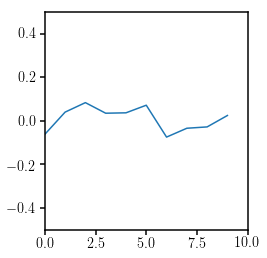

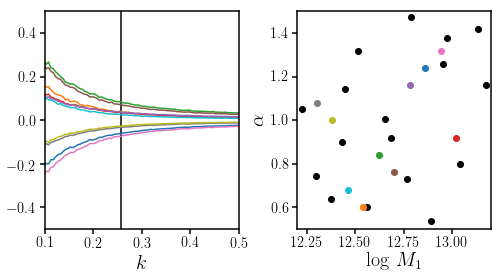

In [76]:

i_k = 50
print karr[i_k]
fig = plt.figure(figsize=(8,4))
sub1 = fig.add_subplot(121)
sub1.plot(range(Y_test.shape[0]), ((Y_test[:,i_k] * sig_p0k_train[i_k] + mu_p0k_train[i_k]) - p0k_test[:,i_k])/p0k_test[:,i])
sub1.set_xlim([0., Y_test.shape[0]])
sub1.set_ylim([-0.5, 0.5])

fig = plt.figure(figsize=(8,4))
sub1 = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
sub2.scatter(thetas[:,3], thetas[:,4], c='k')
pk_ratio = [] 
for ii in range(Y_test.shape[1]): 
    pk_ratio.append(((Y_test[:,ii] * sig_p0k_train[ii] + mu_p0k_train[ii]) - p0k_test[:,ii])/p0k_test[:,i])
pk_ratio = np.array(pk_ratio)

for i in range(Y_test.shape[0]):
    sub1.plot(karr, pk_ratio[:,i], c='C'+str(i))
    sub2.scatter([thetas_test[i,3]], [thetas_test[i,4]], c='C'+str(i))
sub1.vlines(karr[i_k], -1., 1.)#, color='k')#, linestyles='--')
sub1.set_xlim([1e-1, 0.5])
#sub1.set_xscale('log')
sub1.set_xlabel(r'$k$', fontsize=20)
sub1.set_ylim([-0.5, 0.5])

sub2.set_xlim([12.2, 13.2])
sub2.set_xlabel(r'$\log\,M_1$', fontsize=20)
sub2.set_ylim([0.5, 1.5])
sub2.set_ylabel(r'$\alpha$', fontsize=20)
fig.subplots_adjust(wspace=0.3)

0.25753768852


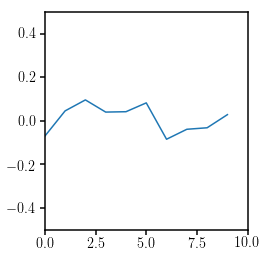

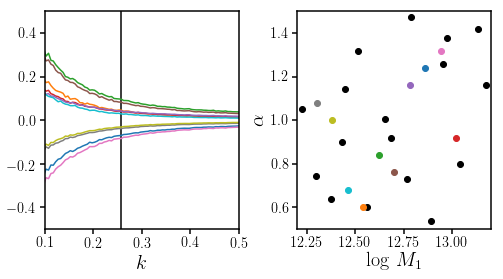

In [77]:
X_train = thetas[:,3:]
mu_p0k_train = np.sum(p0k_lhd, axis=0)/float(p0k_lhd.shape[0])
sig_p0k_train = np.std(p0k_lhd, axis=0)
Y_train = (p0k_lhd - mu_p0k_train)/sig_p0k_train
gp_emu_opt = trainGP_opt(X_train, Y_train)

# testing set
X_test = thetas_train[:,3:]
Y_test, var_test = emu(X_test, gp_emu, Y_train)

i_k = 50
print karr[i_k]
fig = plt.figure(figsize=(8,4))
sub1 = fig.add_subplot(121)
sub1.plot(range(Y_test.shape[0]), ((Y_test[:,i_k] * sig_p0k_train[i_k] + mu_p0k_train[i_k]) - p0k_test[:,i_k])/p0k_test[:,i])
sub1.set_xlim([0., Y_test.shape[0]])
sub1.set_ylim([-0.5, 0.5])

fig = plt.figure(figsize=(8,4))
sub1 = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
sub2.scatter(thetas[:,3], thetas[:,4], c='k')
pk_ratio = [] 
for ii in range(Y_test.shape[1]): 
    pk_ratio.append(((Y_test[:,ii] * sig_p0k_train[ii] + mu_p0k_train[ii]) - p0k_test[:,ii])/p0k_test[:,i])
pk_ratio = np.array(pk_ratio)

for i in range(Y_test.shape[0]):
    sub1.plot(karr, pk_ratio[:,i], c='C'+str(i))
    sub2.scatter([thetas_test[i,3]], [thetas_test[i,4]], c='C'+str(i))
sub1.vlines(karr[i_k], -1., 1.)#, color='k')#, linestyles='--')
sub1.set_xlim([1e-1, 0.5])
#sub1.set_xscale('log')
sub1.set_xlabel(r'$k$', fontsize=20)
sub1.set_ylim([-0.5, 0.5])

sub2.set_xlim([12.2, 13.2])
sub2.set_xlabel(r'$\log\,M_1$', fontsize=20)
sub2.set_ylim([0.5, 1.5])
sub2.set_ylabel(r'$\alpha$', fontsize=20)
fig.subplots_adjust(wspace=0.3)